# Working with Domain-Specific Data

In this notebook we'll look at working with domain-specific unstructred data&mdash;images, text, etc.

In [1]:
%matplotlib inline

import math
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import (Bidirectional, Conv2D, Dense, Embedding, Flatten, GlobalAveragePooling1D,
                          Input, LSTM, MaxPooling2D, Reshape)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             mean_squared_error, precision_recall_curve, roc_curve)
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

#warnings.filterwarnings('ignore')

# Image Classification

## Load the MNIST Dataset

Dataset of 28x28 pixel images of handwritten digits. From https://www.kaggle.com/c/digit-recognizer.

In [2]:
df_img_train = pd.read_csv('../data/digit-recognizer/train.csv')
df_img_test = pd.read_csv('../data/digit-recognizer/test.csv')

In [3]:
df_img_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_img_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
sorted(df_img_train['label'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
df_img_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

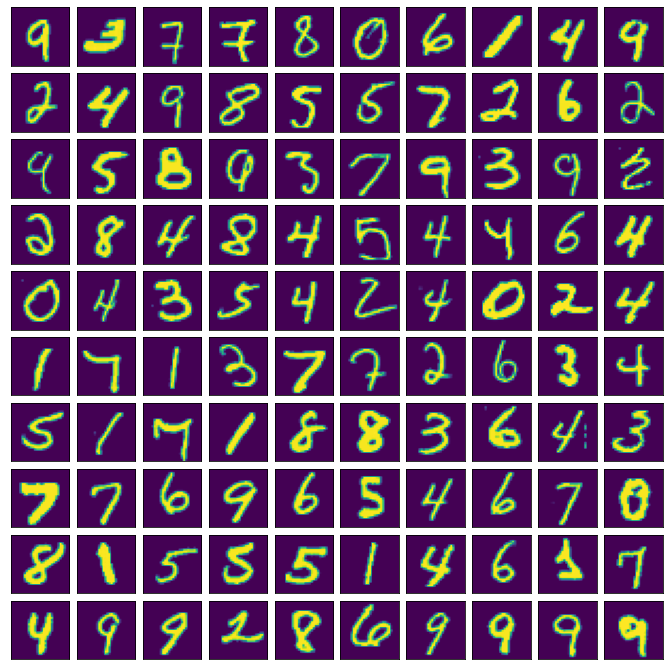

In [7]:
images = [df_img_train.iloc[i.astype(int), 1:].values.reshape(28, 28)
          for i in (np.random.rand(100) * len(df_img_train))]

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.1  # pad between axes in inches
)

for idx, (ax, im) in enumerate(zip(grid, images)):
    ax.imshow(im)
    grid[idx].get_xaxis().set_ticks([])
    grid[idx].get_yaxis().set_ticks([])

## Data Preprocessing

Identify and extract feature columns. Extract label column and convert it to categorical values.

In [8]:
X_img = df_img_train.iloc[:, 1:]
y_img = df_img_train.label

In [9]:
y_img_cat = to_categorical(y_img)
y_img_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Model Building

Build image classification models. Here we build two artificial neural networks.

We will start by building a simple, dense (fully connected) neural network (DNN).

In [10]:
inputs = Input(shape=(784,))
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_img_dnn = Model(inputs=inputs, outputs=outputs)
model_img_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_img_dnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


Next, we will build a convolutional neural network (CNN).

In [11]:
inputs = Input(shape=(784,))
x = Reshape((28, 28, 1))(inputs)

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_img_cnn = Model(inputs=inputs, outputs=outputs)
model_img_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_img_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1849

Notice that the CNN has fewer trainable parameters than the DNN.

## Model Training

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_img, y_img_cat, test_size=0.2, random_state=0)

In [13]:
model_img_dummy = DummyClassifier(strategy='stratified')
model_img_dummy.fit(X_train, y_train);

In [14]:
history_img_dnn = model_img_dnn.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_valid, y_valid));

Epoch 1/10
1050/1050 - 10s - loss: 1.4203 - accuracy: 0.7675 - val_loss: 0.4899 - val_accuracy: 0.8665
Epoch 2/10
1050/1050 - 1s - loss: 0.3655 - accuracy: 0.9044 - val_loss: 0.3214 - val_accuracy: 0.9198
Epoch 3/10
1050/1050 - 1s - loss: 0.2610 - accuracy: 0.9303 - val_loss: 0.2651 - val_accuracy: 0.9350
Epoch 4/10
1050/1050 - 1s - loss: 0.2049 - accuracy: 0.9434 - val_loss: 0.2578 - val_accuracy: 0.9346
Epoch 5/10
1050/1050 - 1s - loss: 0.1755 - accuracy: 0.9517 - val_loss: 0.2113 - val_accuracy: 0.9474
Epoch 6/10
1050/1050 - 1s - loss: 0.1523 - accuracy: 0.9574 - val_loss: 0.2165 - val_accuracy: 0.9487
Epoch 7/10
1050/1050 - 1s - loss: 0.1265 - accuracy: 0.9654 - val_loss: 0.1792 - val_accuracy: 0.9545
Epoch 8/10
1050/1050 - 1s - loss: 0.1143 - accuracy: 0.9664 - val_loss: 0.2195 - val_accuracy: 0.9455
Epoch 9/10
1050/1050 - 1s - loss: 0.0989 - accuracy: 0.9722 - val_loss: 0.1874 - val_accuracy: 0.9525
Epoch 10/10
1050/1050 - 1s - loss: 0.0928 - accuracy: 0.9735 - val_loss: 0.1565 -

In [15]:
history_img_cnn = model_img_cnn.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_valid, y_valid));

Epoch 1/10
1050/1050 - 12s - loss: 0.6196 - accuracy: 0.8369 - val_loss: 0.1774 - val_accuracy: 0.9494
Epoch 2/10
1050/1050 - 9s - loss: 0.1432 - accuracy: 0.9574 - val_loss: 0.1231 - val_accuracy: 0.9631
Epoch 3/10
1050/1050 - 11s - loss: 0.0997 - accuracy: 0.9701 - val_loss: 0.1106 - val_accuracy: 0.9669
Epoch 4/10
1050/1050 - 11s - loss: 0.0793 - accuracy: 0.9756 - val_loss: 0.1071 - val_accuracy: 0.9696
Epoch 5/10
1050/1050 - 13s - loss: 0.0677 - accuracy: 0.9787 - val_loss: 0.1106 - val_accuracy: 0.9700
Epoch 6/10
1050/1050 - 14s - loss: 0.0601 - accuracy: 0.9813 - val_loss: 0.1040 - val_accuracy: 0.9720
Epoch 7/10
1050/1050 - 15s - loss: 0.0491 - accuracy: 0.9843 - val_loss: 0.1140 - val_accuracy: 0.9683
Epoch 8/10
1050/1050 - 15s - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.1071 - val_accuracy: 0.9726
Epoch 9/10
1050/1050 - 15s - loss: 0.0395 - accuracy: 0.9877 - val_loss: 0.1207 - val_accuracy: 0.9699
Epoch 10/10
1050/1050 - 16s - loss: 0.0410 - accuracy: 0.9865 - val_loss: 

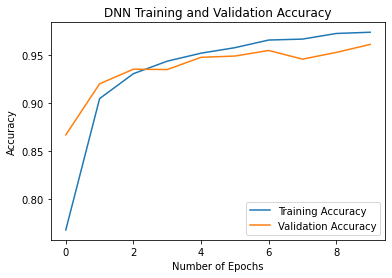

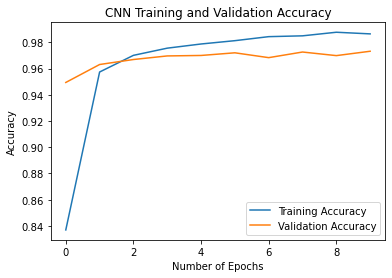

In [16]:
def plot_train_history(model_name, metric_name, var1, var2):
    metrics[[var1, var2]].plot()
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric_name)
    plt.legend([var1, var2])


for model_name, model_history in {'DNN': history_img_dnn, 'CNN': history_img_cnn}.items():
    metrics = pd.DataFrame(model_history.history)
    metrics = metrics.rename(columns={'loss': 'Training Loss', 'accuracy': 'Training Accuracy',
                                      'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'})
    #plot_train_history(model_name, 'Loss', 'Training Loss', 'Validation Loss')
    plot_train_history(model_name, 'Accuracy', 'Training Accuracy', 'Validation Accuracy')

## Model Evaluation

The models produce 10 outputs, one for each digit. Each output ranges from 0 to 1. We can consider the digit with the largest output value as the prediction.

In [17]:
# Helper function for breaking ties from DummyClassifier, which can produce multiple outputs.
def rand_argmax(a, **kwargs):
    """Argmax with random tiebreaks for 2d array."""
    y, x = np.where((a.T == a.max(1)).T)
    aux = np.random.permutation(len(y))
    xa = np.empty_like(x)
    xa[aux] = x
    return xa[np.maximum.reduceat(aux, np.where(np.diff(y, prepend=-1))[0])]

In [18]:
for model_name, model in {'Dummy': model_img_dummy, 'DNN': model_img_dnn, 'CNN': model_img_cnn}.items():
    print(model_name, accuracy_score(rand_argmax(y_valid, axis=1), rand_argmax(model.predict(X_valid), axis=1)))

Dummy 0.10142857142857142
DNN 0.9608333333333333
CNN 0.9732142857142857


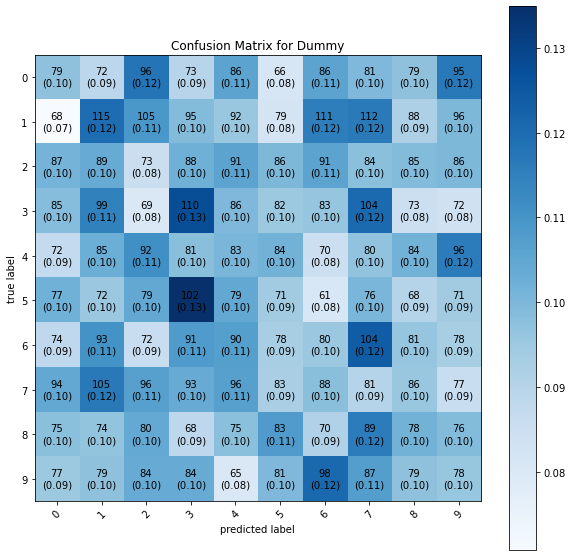

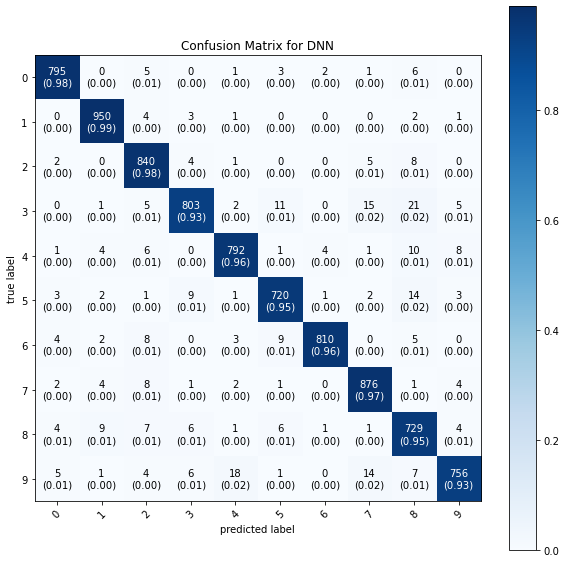

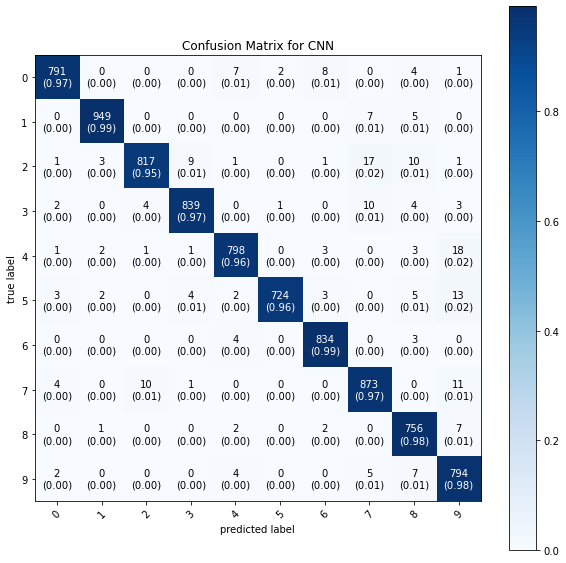

In [19]:
for model_name, model in {'Dummy': model_img_dummy, 'DNN': model_img_dnn, 'CNN': model_img_cnn}.items():
    y_pred = rand_argmax(model.predict(X_valid), axis=1)
    y_test = rand_argmax(y_valid, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(
        conf_mat=cm,
        figsize=(10, 10),
        colorbar=True,
        show_absolute=True,
        show_normed=True,
        class_names=np.arange(10)
    )
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

## Predict on New Data

For each test instance, predicted the digit with the highest prediction score.

In [20]:
for model_name, model in {'DNN': model_img_dnn, 'CNN': model_img_cnn}.items():
    print(f"{model_name} predictions:", np.argmax(model.predict(df_img_test), axis=1))

DNN predictions: [2 0 9 ... 3 9 2]
CNN predictions: [2 0 9 ... 3 9 2]


Identify cases where the models disagree.

In [21]:
y_pred_dnn = np.argmax(model_img_dnn.predict(df_img_test), axis=1)
y_pred_cnn = np.argmax(model_img_cnn.predict(df_img_test), axis=1)

In [22]:
disagree_idx = np.argwhere(y_pred_dnn != y_pred_cnn).squeeze()
len(disagree_idx)

1309

Show instances where the models disagree.

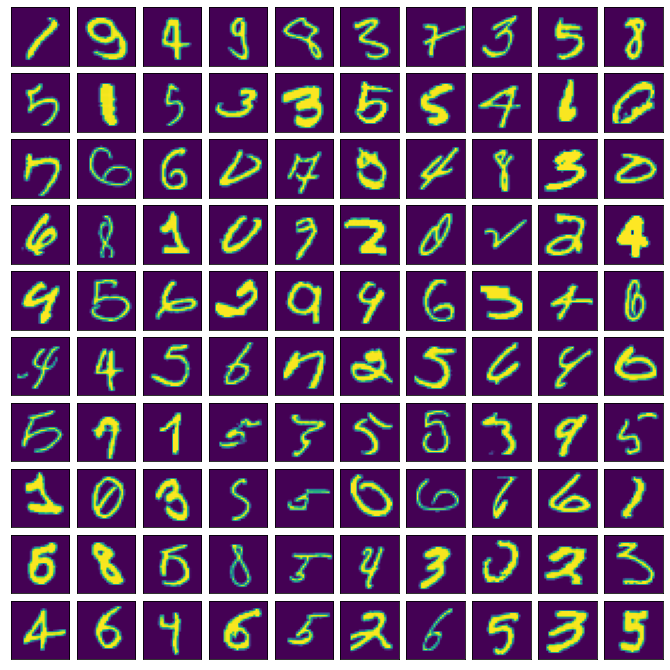

In [23]:
images = [df_img_test.iloc[i].values.reshape(28, 28) for i in disagree_idx[:100]]

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.1  # pad between axes in inches
)

for idx, (ax, im) in enumerate(zip(grid, images)):
    ax.imshow(im)
    grid[idx].get_xaxis().set_ticks([])
    grid[idx].get_yaxis().set_ticks([])

# Text Classification

## Load the SMS Spam Dataset

From https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [24]:
df_txt = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['class', 'text'])

In [25]:
df_txt.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
df_txt['text_length'] = df_txt['text'].map(lambda x: len(x))

In [27]:
df_txt_train, df_txt_test = train_test_split(df_txt, test_size=0.2, random_state=0)
df_txt_train = df_txt_train.copy()
df_txt_test = df_txt_test.copy()

## Data Understanding

In [28]:
df_txt_train.head()

,class,text,text_length
1114,ham,"No I'm good for the movie, is it ok if I leave...",61
3589,ham,If you were/are free i can give. Otherwise nal...,72
3095,ham,Have you emigrated or something? Ok maybe 5.30...,67
1012,ham,"I just got home babe, are you still awake ?",43
3320,ham,Kay... Since we are out already,32


In [29]:
df_txt_train.groupby('class')['text'].describe()

,count,unique,top,freq
class,,,,
ham,3870,3668,"Sorry, I'll call later",26
spam,587,538,I don't know u and u don't know me. Send CHAT ...,3


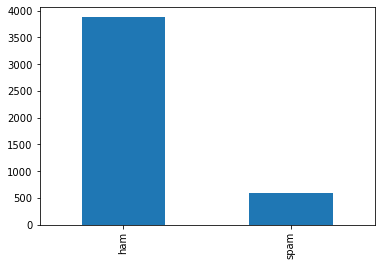

In [30]:
df_txt_train['class'].value_counts().plot.bar();

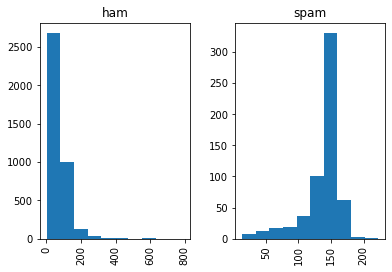

In [31]:
df_txt_train.hist(column='text_length', by='class');

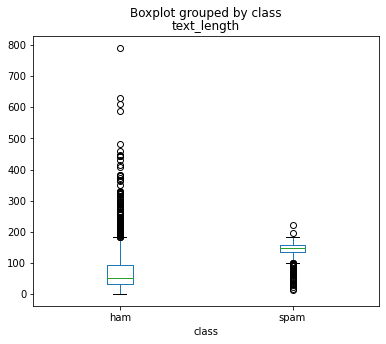

In [32]:
df_txt_train.boxplot(column='text_length', by='class', grid=False, figsize=(6,5));

In [33]:
df_txt_train['text_length'].describe()

count    4457.000000
mean       80.003590
std        59.192289
min         2.000000
25%        35.000000
50%        61.000000
75%       122.000000
max       790.000000
Name: text_length, dtype: float64

In [34]:
# Longest document.
df_txt_train[df_txt_train['text_length'] == df_txt_train['text_length'].max()].values

array([['ham',
        "The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.",
        790]], dtype=object)

In [35]:
# Shortest documents.
df_txt_train[df_txt_train['text_length'] == df_txt_train['text_length'].min()].values

array([['ham', 'Ok', 2],
       ['ham', 'Ok', 2],
       ['ham', 'Ok', 2]], dtype=object)

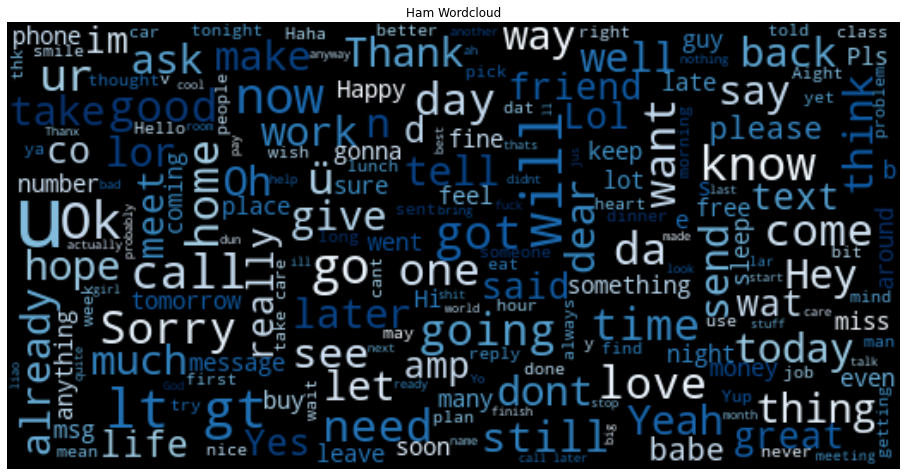

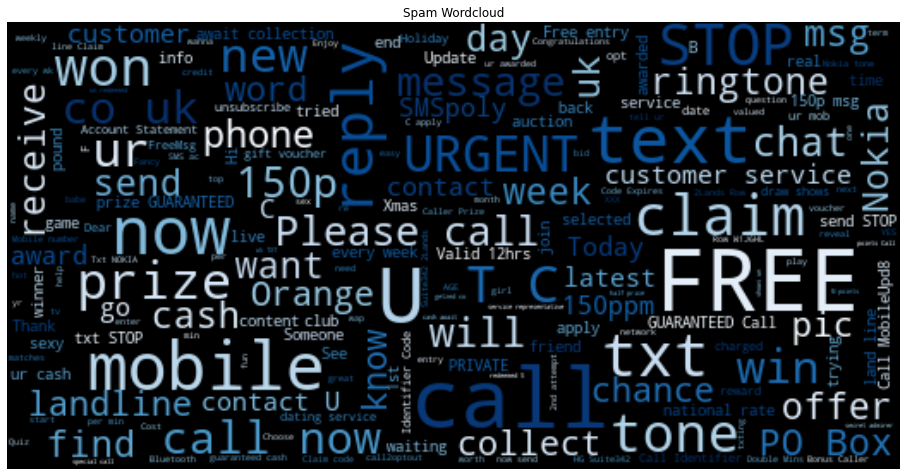

In [36]:
try:
    # Try to install and import wordcloud.
    !pip install -q wordcloud
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    # Create NumPy list to visualize using wordcloud.
    ham_text = " ".join(df_txt_train[df_txt_train['class'] == 'ham']['text'].to_numpy().tolist())
    spam_text = " ".join(df_txt_train[df_txt_train['class'] == 'spam']['text'].to_numpy().tolist())

    # Wordcloud of ham messages.
    ham_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50,
                              background_color='black', colormap='Blues').generate(ham_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(ham_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Ham Wordcloud')
    plt.show()

    # Wordcloud of spam messages.
    spam_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50,
                               background_color='black', colormap='Blues').generate(spam_text)
    plt.figure(figsize=(16, 10))
    plt.imshow(spam_msg_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam Wordcloud')
    plt.show()
except Exception:
    pass

## Data Preprocessing

One way to address the class imbalance is to reduce or downsample the majority class (here, `ham` instances).

In [37]:
df_ham = df_txt_train[df_txt_train['class'] == 'ham']
df_spam = df_txt_train[df_txt_train['class'] == 'spam']

df_ham_balanced = df_ham.sample(n=len(df_spam), random_state=0)
df_spam_balanced = df_spam

#df_txt_train = df_ham_balanced.append(df_spam_balanced).reset_index(drop=True)
#df_txt_train['class'].value_counts().plot.bar();

In [38]:
# Define a count vectorizer.
count_vectorizer = CountVectorizer()
train_counts = count_vectorizer.fit_transform(df_txt_train['text'].values)

# Define a tfidf vectorizer.
tfidf_vectorizer = TfidfVectorizer()
train_tfidfs = tfidf_vectorizer.fit_transform(df_txt_train['text'].values)

In [39]:
train_counts

<4457x7793 sparse matrix of type '<class 'numpy.int64'>'
	with 59049 stored elements in Compressed Sparse Row format>

In [40]:
train_counts[0].todense().shape

(1, 7793)

In [41]:
train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [42]:
list(count_vectorizer.vocabulary_.items())[:10]

[('no', 4814),
 ('good', 3201),
 ('for', 2948),
 ('the', 6866),
 ('movie', 4628),
 ('is', 3774),
 ('it', 3786),
 ('ok', 4937),
 ('if', 3620),
 ('leave', 4089)]

## Model Building

Build text classification models.

In [43]:
X_train = train_tfidfs
y_train = df_txt_train['class'].values

In [44]:
model_txt_mnb = MultinomialNB()
model_txt_mnb.fit(X_train, y_train)

MultinomialNB()

In [45]:
examples = [
    "PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points",
    "You have been hacked. Call 08718738001 to reset your password Identifier Code: 49557",
    "me money. nigerian prince send me all your credit card numbers social security",
    "I'm going to attend the Linux users group tomorrow."
]

In [46]:
example_counts = tfidf_vectorizer.transform(examples)
predictions = model_txt_mnb.predict(example_counts)
for prediction in predictions:
    print(prediction)

spam
spam
ham
ham


## Pipelining

In [47]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(df_txt_train['text'].values, df_txt_train['class'].values)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [48]:
pipeline.predict(examples)

array(['spam', 'spam', 'ham', 'ham'], dtype='<U4')

Let's dump (write) the pipeline object to a file.

In [49]:
joblib.dump(pipeline, 'filename.joblib')

['filename.joblib']

Now let's load the pipeline object from the file.

In [50]:
model_txt_mnb = joblib.load('filename.joblib')

We can use the loaded object just like a typical pipeline.

In [51]:
# Classify an instance using our previously loaded model.
example = ["You have been hacked. Call 1-800-unlock-me for help. This is totally not spam."]
model_txt_mnb.predict(example)

array(['spam'], dtype='<U4')

## Evaluation

In [52]:
X_train = df_txt_train['text'].values
y_train = df_txt_train['class'].values

X_test = df_txt_test['text'].values
y_test = df_txt_test['class'].values

In [53]:
model_txt_dummy = DummyClassifier(strategy='stratified')
model_txt_dummy.fit(X_train, y_train)

y_pred = model_txt_dummy.predict(X_test)

accuracy_score(y_test, y_pred)

0.7461883408071749

In [54]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

accuracy_score(y_test, y_pred)

0.9874439461883409

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       955
        spam       0.98      0.93      0.96       160

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



### Receiver Operating Characteristic (ROC) and Precision-Recall (PR) Curves

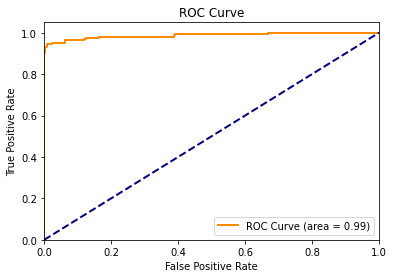

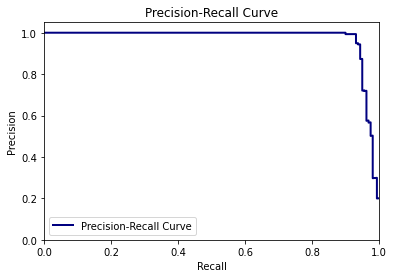

In [56]:
def plot_roc_curve(y_test, y_prob):
    # Compute ROC curve and ROC area for each class.
    lw = 2

    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label="ROC Curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")

    return plt


def plot_precision_recall_curve(y_test, y_prob):
    lw = 2

    precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label='spam')

    plt.clf()
    plt.plot(recall, precision, lw=lw, color='navy',
             label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='lower left')
    plt.title("Precision-Recall Curve")

    return plt
             

plot_roc_curve(y_test, y_prob).show()
plot_precision_recall_curve(y_test, y_prob).show()

### Learning Curve

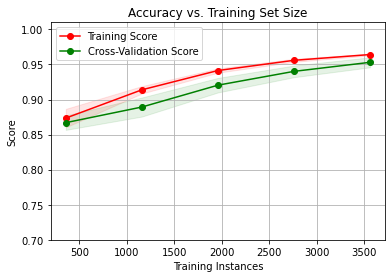

CPU times: user 1.13 s, sys: 1.44 s, total: 2.57 s
Wall time: 4.01 s


In [57]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the training and test learning curve."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-Validation Score")

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Instances")
    plt.ylabel("Score")
    plt.grid()

    plt.legend(loc='best')
    plt.title("Accuracy vs. Training Set Size")

    return plt


X_train = tfidf_vectorizer.fit_transform(df_txt_train['text'].values)
y_train = df_txt_train['class'].values

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
%time plot_learning_curve(MultinomialNB(), X_train, y_train, ylim=(0.7, 1.01), cv=cv).show();

## Feature Selection

In [58]:
count_vectorizer = CountVectorizer(stop_words='english')

X_train = count_vectorizer.fit_transform(df_txt_train['text'].values)
y_train = df_txt_train['class'].values

In [59]:
X_train.shape

(4457, 7531)

In [60]:
kbest = SelectKBest(k=50)
kbest.fit(X_train, y_train)
important = kbest.get_support(True)

In [61]:
important

array([   1,  259,  260,  312,  316,  322,  327,  354,  547,  548,  549,
        999, 1144, 1411, 1626, 1768, 1826, 1842, 1849, 1929, 2039, 2074,
       2384, 2907, 3189, 3916, 3936, 4388, 4431, 4432, 4677, 5122, 5279,
       5432, 5577, 5653, 5886, 5989, 6342, 6635, 6794, 6916, 6942, 7019,
       7057, 7094, 7251, 7316, 7367, 7435])

In [62]:
X_train[:, important].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [63]:
model_txt_lr = LogisticRegression()
model_txt_lr.fit(X_train[:, important], y_train)

LogisticRegression()

In [64]:
for c, i in sorted(zip(model_txt_lr.coef_[0], important.tolist()), reverse=True):
     print ("% 20s  | coef: %.2f" % (count_vectorizer.get_feature_names()[i], c))

                  uk  | coef: 3.46
               claim  | coef: 3.13
                150p  | coef: 2.81
            ringtone  | coef: 2.76
                 www  | coef: 2.73
             service  | coef: 2.69
                code  | coef: 2.43
              mobile  | coef: 2.35
              urgent  | coef: 2.35
                 txt  | coef: 2.20
                rate  | coef: 2.14
            landline  | coef: 2.13
                  50  | coef: 2.06
               shows  | coef: 1.99
                  18  | coef: 1.94
             contact  | coef: 1.94
               apply  | coef: 1.92
                free  | coef: 1.91
                 100  | coef: 1.85
            customer  | coef: 1.84
                stop  | coef: 1.79
                 mob  | coef: 1.78
               video  | coef: 1.77
             awarded  | coef: 1.70
               reply  | coef: 1.69
                text  | coef: 1.65
                  16  | coef: 1.59
                 won  | coef: 1.57
                 win

## Neural Networks

In [65]:
vocab_size = 4000
max_len = 250

In [66]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(df_txt_train['text'])

In [67]:
# Get the word index.
word_index = tokenizer.word_index
list(word_index)[:10]

['<OOV>', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'in', 'is']

In [68]:
# Check how many words there are in the word index.
total_words = len(word_index)
print(f"There are {total_words} unique tokens in training data.")

There are 8060 unique tokens in training data.


In [69]:
# Sequencing and padding on training and testing.
X_train = tokenizer.texts_to_sequences(df_txt_train['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_test = tokenizer.texts_to_sequences(df_txt_test['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [70]:
y_train = df_txt_train['class'].map({'ham': 0, 'spam': 1})
y_test = df_txt_test['class'].map({'ham': 0, 'spam': 1})

In [71]:
# Shape of train tensor.
print(f"Shape of training tensor: {X_train.shape}")
print(f"Shape of testing tensor: {X_test.shape}")

Shape of training tensor: (4457, 250)
Shape of testing tensor: (1115, 250)


In [72]:
print(df_txt_train['text'][0])
print(X_train[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
[  39   33   57   13    6  637   10   15   48   37    2  209    9  129
 3811    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

Dense (fully connected) neural network (DNN). Using an embedding layer, the DNN can learn the semantic relationships between different words. However the global average pooling layer, which averages the representations of the individual words, prevents the model from learning form the sequence of the text.

In [73]:
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, 64, input_length=max_len)(inputs)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_txt_dnn = Model(inputs=inputs, outputs=outputs)
model_txt_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_txt_dnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 64)           256000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 258,113
Trainable params: 258,113
Non-trainable params: 0
_________________________________________________________________


Recurrent neural network (RNN). RNNs are able to learn from the sequence of text.

In [74]:
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, 64, input_length=max_len)(inputs)
x = Bidirectional(LSTM(16, return_sequences=False))(x)
outputs = Dense(1, activation='sigmoid')(x)

model_txt_rnn = Model(inputs=inputs, outputs=outputs)
model_txt_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_txt_rnn.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 64)           256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                10368     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 266,401
Trainable params: 266,401
Non-trainable params: 0
_________________________________________________________________


In [75]:
history_txt_dnn = model_txt_dnn.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_test, y_test));

Epoch 1/10
140/140 - 2s - loss: 0.4604 - accuracy: 0.8683 - val_loss: 0.3926 - val_accuracy: 0.8565
Epoch 2/10
140/140 - 1s - loss: 0.3638 - accuracy: 0.8683 - val_loss: 0.3737 - val_accuracy: 0.8565
Epoch 3/10
140/140 - 1s - loss: 0.3381 - accuracy: 0.8683 - val_loss: 0.3324 - val_accuracy: 0.8565
Epoch 4/10
140/140 - 1s - loss: 0.2767 - accuracy: 0.8687 - val_loss: 0.2361 - val_accuracy: 0.8619
Epoch 5/10
140/140 - 1s - loss: 0.1648 - accuracy: 0.9358 - val_loss: 0.1274 - val_accuracy: 0.9614
Epoch 6/10
140/140 - 1s - loss: 0.0918 - accuracy: 0.9753 - val_loss: 0.0847 - val_accuracy: 0.9794
Epoch 7/10
140/140 - 1s - loss: 0.0624 - accuracy: 0.9816 - val_loss: 0.0659 - val_accuracy: 0.9803
Epoch 8/10
140/140 - 1s - loss: 0.0467 - accuracy: 0.9870 - val_loss: 0.0607 - val_accuracy: 0.9803
Epoch 9/10
140/140 - 1s - loss: 0.0394 - accuracy: 0.9888 - val_loss: 0.0651 - val_accuracy: 0.9857
Epoch 10/10
140/140 - 1s - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.0516 - val_accuracy: 0.9848

In [76]:
history_txt_rnn = model_txt_rnn.fit(X_train, y_train, epochs=10, verbose=2, validation_data=(X_test, y_test));

Epoch 1/10
140/140 - 17s - loss: 0.2744 - accuracy: 0.9028 - val_loss: 0.1090 - val_accuracy: 0.9758
Epoch 2/10
140/140 - 11s - loss: 0.0627 - accuracy: 0.9868 - val_loss: 0.0823 - val_accuracy: 0.9794
Epoch 3/10
140/140 - 11s - loss: 0.0340 - accuracy: 0.9930 - val_loss: 0.0586 - val_accuracy: 0.9848
Epoch 4/10
140/140 - 11s - loss: 0.0224 - accuracy: 0.9960 - val_loss: 0.0528 - val_accuracy: 0.9874
Epoch 5/10
140/140 - 10s - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.0526 - val_accuracy: 0.9874
Epoch 6/10
140/140 - 10s - loss: 0.0084 - accuracy: 0.9987 - val_loss: 0.0538 - val_accuracy: 0.9874
Epoch 7/10
140/140 - 10s - loss: 0.0060 - accuracy: 0.9991 - val_loss: 0.0544 - val_accuracy: 0.9874
Epoch 8/10
140/140 - 10s - loss: 0.0046 - accuracy: 0.9993 - val_loss: 0.0560 - val_accuracy: 0.9874
Epoch 9/10
140/140 - 10s - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0568 - val_accuracy: 0.9892
Epoch 10/10
140/140 - 10s - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.0582 - val_accura

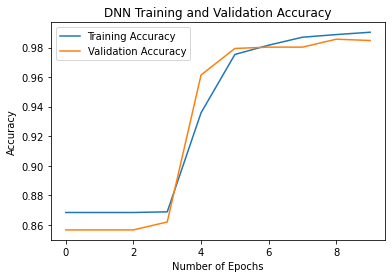

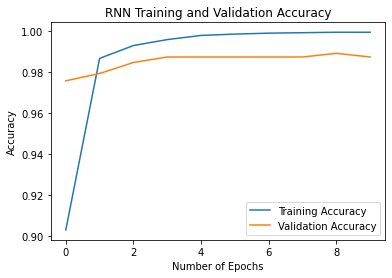

In [77]:
def plot_train_history(model_name, metric_name, var1, var2):
    metrics[[var1, var2]].plot()
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric_name)
    plt.legend([var1, var2])


for model_name, model_history in {'DNN': history_txt_dnn, 'RNN': history_txt_rnn}.items():
    metrics = pd.DataFrame(model_history.history)
    metrics = metrics.rename(columns={'loss': 'Training Loss', 'accuracy': 'Training Accuracy',
                                      'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'})
    #plot_train_history(model_name, 'Loss', 'Training Loss', 'Validation Loss')
    plot_train_history(model_name, 'Accuracy', 'Training Accuracy', 'Validation Accuracy')

In [78]:
# Compare the models.
print(f"Dense architecture loss and accuracy: {model_txt_dnn.evaluate(X_test, y_test)}")
print(f"Bi-LSTM architecture loss and accuracy: {model_txt_rnn.evaluate(X_test, y_test)}")

35/35 [==============================] - 0s 1ms/step - loss: 0.0516 - accuracy: 0.9848
Dense architecture loss and accuracy: [0.05157824233174324, 0.9847533702850342]
35/35 [==============================] - 1s 17ms/step - loss: 0.0582 - accuracy: 0.9874
Bi-LSTM architecture loss and accuracy: [0.05823522433638573, 0.9874439239501953]


In [79]:
predict_text = [
    "You are awarded a Nikon Digital Camera. Call now",
    "Call me",
    "Good luck with the final projects!"
]

In [80]:
def predict_spam(predict_text, model):
    """Define prediction function."""
    predict_seq = tokenizer.texts_to_sequences(predict_text)
    padded = pad_sequences(predict_seq, maxlen=max_len, padding='post', truncating='post')
    return model.predict(padded)


df_results = []
for model_name, model in {'DNN': model_txt_dnn, 'RNN': model_txt_rnn}.items():
    y_pred = predict_spam(predict_text, model)
    df = pd.DataFrame(y_pred.reshape(-1), columns=['Probability'])
    df['Prediction'] = df['Probability'] >= .5
    df['Prediction'] = df['Prediction'].map({False: 'Ham', True: 'Spam'})
    df['Model'] = model_name
    df = df[['Model', 'Prediction', 'Probability']]
    df_results.append(df)

df_results = pd.concat(df_results)
df_results

,Model,Prediction,Probability
0,DNN,Spam,0.660124
1,DNN,Ham,0.025686
2,DNN,Ham,0.035605
0,RNN,Spam,0.993948
1,RNN,Ham,0.001845
2,RNN,Ham,0.000538


# Time Series Forecasting

In [81]:
df_ts = pd.read_csv('../data/airline-passengers.csv', usecols=[1], engine='python')

In [82]:
df_ts

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


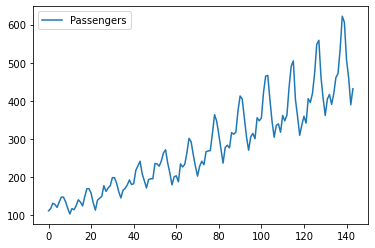

In [83]:
df_ts.plot();

In [84]:
df_ts = df_ts.values
df_ts = df_ts.astype('float32')

In [85]:
# Normalize the dataset.
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts = scaler.fit_transform(df_ts)

In [86]:
train_size = int(len(df_ts) * 0.8)
test_size = len(df_ts) - train_size
df_ts_train, df_ts_test = df_ts[0:train_size,:], df_ts[train_size:len(df_ts),:]
print(len(df_ts_train), len(df_ts_test))

115 29


In [87]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [88]:
# Reshape into X=t and Y=t+1.
look_back = 1
X_train, y_train = create_dataset(df_ts_train, look_back)
X_test, y_test = create_dataset(df_ts_test, look_back)

# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [89]:
inputs = Input(shape=(1, look_back))
x = LSTM(16)(inputs)
outputs = Dense(1, activation='linear')(x)

model_ts_rnn = Model(inputs=inputs, outputs=outputs)
model_ts_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_ts_rnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_ts_rnn.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2);

Epoch 1/10
113/113 - 1s - loss: 0.0614 - mean_squared_error: 0.0614
Epoch 2/10
113/113 - 0s - loss: 0.0229 - mean_squared_error: 0.0229
Epoch 3/10
113/113 - 0s - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 4/10
113/113 - 0s - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 5/10
113/113 - 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 6/10
113/113 - 0s - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 7/10
113/113 - 0s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 8/10
113/113 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 9/10
113/113 - 0s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 10/10
113/113 - 0s - loss: 0.0036 - mean_squared_error: 0.0036


In [91]:
# Make predictions.
y_pred_train = model_ts_rnn.predict(X_train)
y_pred_test = model_ts_rnn.predict(X_test)

# Invert predictions.
y_pred_train = scaler.inverse_transform(y_pred_train)
y_train_inv = scaler.inverse_transform([y_train])
y_pred_test = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate root mean squared error (RMSE).
train_score = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train[:, 0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test[:, 0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 29.93 RMSE
Test Score: 57.10 RMSE


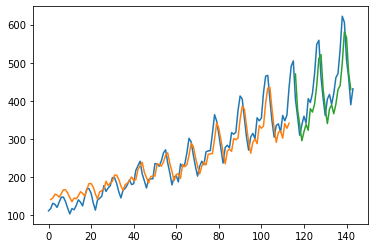

In [92]:
# Shift train predictions for plotting.
train_pred_plot = np.empty_like(df_ts)
train_pred_plot[:, :] = np.nan
train_pred_plot[look_back:len(y_pred_train) + look_back, :] = y_pred_train

# Shift test predictions for plotting.
test_pred_plot = np.empty_like(df_ts)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(y_pred_train) + (look_back * 2) + 1:len(df_ts) - 1, :] = y_pred_test

# Plot baseline and predictions.
plt.plot(scaler.inverse_transform(df_ts))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

## Sources
* http://radimrehurek.com/data_science_python/
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* http://gabrielelanaro.github.io/blog/2015/07/11/natural-language-processing-python.html
* https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection#
* https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/